<a href="https://colab.research.google.com/github/atzzom/pgd/blob/main/pgd%20-%20pedro%20avila.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Publicis technical test by Pedro Ávila

## table of contents

* analytic test
  - data load
  - cleaning
    - google analytics
      - feature engineering
      - exporting
    - doubleclick
      - feature engineering
      - exporting
  - exploratory data analysis
  - visualization
* SQL assessment

***please allow the authentication request with your email to connect the notebook to the cloud storage bucket with the dataset***

## analytic test

1. what will be your approach in analyzing this datset?
2. what insights can you draw from this data set?
3. what additional information would you need to provide deeper insights?
4. what would you recommend a marketer could do based on this data?
5. what format would you use to report findings?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()
print('authenticated')

authenticated


In [2]:
pd.set_option('display.max_columns', None)

### data load

In [3]:
%%bigquery --project publicis-361421 ga_raw
SELECT *
FROM `publicis-361421.BucketMarketing.google analytics`

In [4]:
%%bigquery --project publicis-361421 dcm_raw
SELECT * FROM `publicis-361421.BucketMarketing.doubleclick`

### cleaning

#### google analytics

In [5]:
ga_interim = ga_raw.copy()

In [6]:
ga_interim.columns = map(str.lower, ga_interim.columns)

In [7]:
ga_interim.rename(columns={
    'month_of_year':'yyyymm',
    'device_category':'device',
    'session_duration':'session_duration_sec'
}, inplace=True)

In [8]:
ga_interim['yyyymm'] = ga_interim['yyyymm'].astype(str)
ga_interim['year'] = ga_interim['yyyymm'].str[:4]
ga_interim['month'] = ga_interim['yyyymm'].str[-2:]
ga_interim['yyyy-mm'] = ga_interim['year'] + "-" + ga_interim['month']

##### feature engineering

In [9]:
ga_interim['session_duration_hr'] = ga_interim['session_duration_sec'] / 3600

In [10]:
ga_interim['pageviews_per_session'] = ga_interim['pageviews'] / ga_interim['sessions']
ga_interim['pageviews_per_user'] = ga_interim['pageviews'] / ga_interim['users']
ga_interim['sessions_per_user'] = ga_interim['sessions'] / ga_interim['users']
ga_interim['returning_ratio'] = ga_interim['new_users'] / ga_interim['users']
ga_interim['onsite_time_sec'] = ga_interim['session_duration_sec'] / ga_interim['users']
ga_interim['onsite_time_hr'] = ga_interim['session_duration_hr'] / ga_interim['users']

In [11]:
ga_interim['tool'] = 'GA'

In [12]:
ga_interim['yyyymm'] = ga_interim['yyyymm'].astype('category')
ga_interim['year'] = ga_interim['year'].astype('category')
ga_interim['month'] = ga_interim['month'].astype('category')
ga_interim['yyyy-mm'] = ga_interim['yyyy-mm'].astype('category')
ga_interim['source'] = ga_interim['source'].astype('category')
ga_interim['device'] = ga_interim['device'].astype('category')
ga_interim['ad_content'] = ga_interim['ad_content'].astype('category')
ga_interim['tool'] = ga_interim['tool'].astype('category')

In [13]:
ga_interim = ga_interim[['tool',
                         'yyyy-mm', 'yyyymm', 'year', 'month',
                         'source', 'device', 'ad_content',
                         'pageviews', 'sessions', 'session_duration_sec', 'session_duration_hr',
                         'users', 'new_users', 
                         'pageviews_per_session', 'pageviews_per_user', 'sessions_per_user',
                         'onsite_time_sec', 'onsite_time_hr',
                         'returning_ratio',
                         'calculated_atos']]

In [14]:
ga_interim.head()

,tool,yyyy-mm,yyyymm,year,month,source,device,ad_content,pageviews,sessions,session_duration_sec,session_duration_hr,users,new_users,pageviews_per_session,pageviews_per_user,sessions_per_user,onsite_time_sec,onsite_time_hr,returning_ratio,calculated_atos
0,GA,2021-04,202104,2021,04,Aptus,NaN,AptusDermicoolRetailDTP.NU1712.320x50,840,331,18129,5.035833,254,251,2.537764,3.307087,1.303150,71.374016,0.019826,0.988189,0.209826
1,GA,2021-04,202104,2021,04,Aptus,NaN,AptusDermicoolLTCDTP.NU1545.320x50,171,118,6001,1.666944,99,97,1.449153,1.727273,1.191919,60.616162,0.016838,0.979798,0.069456
2,GA,2021-04,202104,2021,04,Facebook,NaN,FBNU1795.FBNU1795.1,1960,1840,18128,5.035556,1767,1681,1.065217,1.109225,1.041313,10.259196,0.002850,0.951330,0.209815
3,GA,2021-04,202104,2021,04,Facebook,NaN,FBNU1770.FBNU1770.1,941,883,12553,3.486944,842,819,1.065685,1.117577,1.048694,14.908551,0.004141,0.972684,0.145289
4,GA,2021-04,202104,2021,04,Facebook,NaN,FBNU1796.FBNU1796.1,163,142,1714,0.476111,132,118,1.147887,1.234848,1.075758,12.984848,0.003607,0.893939,0.019838


##### exporting

In [15]:
ga = ga_interim.copy()
# cannonical dataset for analysis to be uploaded to the cloud
# this could be done directly from Colab depending on the active services
ga.to_csv('ga.csv', index=False)

#### doubleclick

In [16]:
dcm_interim = dcm_raw.copy()

In [17]:
dcm_interim.columns = map(str.lower, dcm_interim.columns)

In [18]:
dcm_interim.columns

Index(['campaign', 'month', 'site__site_directory_', 'placement___dcm',
       'creative', 'creative_dimensions', 'platform_type', 'impressions',
       'clicks'],
      dtype='object')

In [19]:
dcm_interim.rename(columns={
    'month':'yyyy-mm',
    'site__site_directory_':'source',
    'placement___dcm':'placement',
    'platform_type':'device'
}, inplace=True)

In [20]:
dcm_interim['yyyy-mm'] = dcm_interim['yyyy-mm'].astype(str)
dcm_interim['year'] = dcm_interim['yyyy-mm'].str[:4]
dcm_interim['month'] = dcm_interim['yyyy-mm'].str[-2:]

In [21]:
# renaming for source consistency with google analytics data
dcm_interim['source'] = dcm_interim['source'].replace('Adprime Media Inc', 'AdPrime')
dcm_interim['source'] = dcm_interim['source'].replace('Adtheorent', 'AdTheorent')
dcm_interim['source'] = dcm_interim['source'].replace('Aptus Health', 'Aptus')
dcm_interim['source'] = dcm_interim['source'].replace('goodrx.com', 'GoodRx')
dcm_interim['source'] = dcm_interim['source'].replace('Health Union, LLC', 'HealthUnion')
dcm_interim['source'] = dcm_interim['source'].replace('Health Union', 'HealthUnion')
dcm_interim['source'] = dcm_interim['source'].replace('Media IQ', 'MediaIQ')
dcm_interim['source'] = dcm_interim['source'].replace('Media IQ', 'MediaIQ')
dcm_interim['source'] = dcm_interim['source'].replace('Medicx Media Solutions', 'Medicx')
dcm_interim['source'] = dcm_interim['source'].replace('Remedy Health', 'RemedyHealth')
dcm_interim['source'] = dcm_interim['source'].replace('Remedy Health Media, LLC', 'RemedyHealth')
dcm_interim['source'] = dcm_interim['source'].replace('Zeta Global', 'Zeta')

In [22]:
dcm_interim['device'] = dcm_interim['device'].str.lower()
dcm_interim['device'] = dcm_interim['device'].replace('(not set)', np.NaN)
dcm_interim['device'] = dcm_interim['device'].replace('unknown platform', np.NaN)
dcm_interim['device'] = dcm_interim['device'].replace('mobile midrange: feature phone', 'phone')
dcm_interim['device'] = dcm_interim['device'].replace('smartphone', 'mobile')

In [23]:
dcm_interim['creative'] = dcm_interim['creative'].replace('(not set)', np.NaN)
dcm_interim['creative_dimensions'] = dcm_interim['creative_dimensions'].replace('(not set)', np.NaN)

##### feature engineering

In [24]:
dcm_interim['ctr'] = dcm_interim['clicks'] / dcm_interim['impressions']

In [25]:
dcm_interim.head()

,campaign,yyyy-mm,source,placement,creative,creative_dimensions,device,impressions,clicks,year,month,ctr
0,200 Arabia Dermicool FY21 SDP DTP Media PT,2021-09,Emodo,SD App Users,SD_1624_v3_Symptom,320x50,connected tv,2,0,2021,09,0.000000
1,200 Arabia Dermicool FY21 SDP DTP Media PT,2021-09,Emodo,SD App Users,SD_1624_v3_Symptom,320x50,desktop,20517,3,2021,09,0.000146
2,200 Arabia Dermicool FY21 SDP DTP Media PT,2021-09,Emodo,SD App Users,SD_1624_v3_Symptom,320x50,phone,6,0,2021,09,0.000000
3,200 Arabia Dermicool FY21 SDP DTP Media PT,2021-09,Emodo,SD App Users,SD_1624_v3_Symptom,320x50,mobile,2289618,2337,2021,09,0.001021
4,200 Arabia Dermicool FY21 SDP DTP Media PT,2021-09,Emodo,SD App Users,SD_1624_v3_Symptom,320x50,tablet,97054,68,2021,09,0.000701


In [26]:
dcm_interim['ctr'] = dcm_interim['ctr'].replace(np.NaN, 0)

In [27]:
creative_type_dic = {
    '1x1':'pixel',
    '160x600':'banner vertical',
    '320x50':'banner small',
    '728x90':'banner',
    '300x250':'square',
    np.NaN:'unknown'
}

In [28]:
dcm_interim['creative_type'] = dcm_interim['creative_dimensions'].map(creative_type_dic)

In [29]:
creative_category_dic = {
    '1x1':'pixel',
    '160x600':'image',
    '320x50':'image',
    '728x90':'image',
    '300x250':'image',
    np.NaN:'unknown'
}

In [30]:
dcm_interim['creative_cat'] = dcm_interim['creative_dimensions'].map(creative_category_dic)

In [31]:
dcm_interim['tool'] = 'DCM'

In [32]:
dcm_interim['tool'] = dcm_interim['tool'].astype('category')
dcm_interim['yyyy-mm'] = dcm_interim['yyyy-mm'].astype('category')
dcm_interim['year'] = dcm_interim['year'].astype('category')
dcm_interim['month'] = dcm_interim['month'].astype('category')
dcm_interim['source'] = dcm_interim['source'].astype('category')
dcm_interim['device'] = dcm_interim['device'].astype('category')
dcm_interim['campaign'] = dcm_interim['campaign'].astype('category')
dcm_interim['placement'] = dcm_interim['placement'].astype('category')
dcm_interim['creative'] = dcm_interim['creative'].astype('category')
dcm_interim['creative_dimensions'] = dcm_interim['creative_dimensions'].astype('category')
dcm_interim['creative_type'] = dcm_interim['creative_type'].astype('category')
dcm_interim['creative_cat'] = dcm_interim['creative_cat'].astype('category')

In [33]:
dcm_interim = dcm_interim[['tool',
                           'yyyy-mm', 'year', 'month',
                           'source', 'device', 'campaign', 'placement',
                           'creative', 'creative_dimensions', 'creative_type', 'creative_cat',
                           'impressions', 'clicks',  'ctr']]

In [34]:
dcm_interim

,tool,yyyy-mm,year,month,source,device,campaign,placement,creative,creative_dimensions,creative_type,creative_cat,impressions,clicks,ctr
0,DCM,2021-09,2021,09,Emodo,connected tv,200 Arabia Dermicool FY21 SDP DTP Media PT,SD App Users,SD_1624_v3_Symptom,320x50,banner small,image,2,0,0.000000
1,DCM,2021-09,2021,09,Emodo,desktop,200 Arabia Dermicool FY21 SDP DTP Media PT,SD App Users,SD_1624_v3_Symptom,320x50,banner small,image,20517,3,0.000146
2,DCM,2021-09,2021,09,Emodo,phone,200 Arabia Dermicool FY21 SDP DTP Media PT,SD App Users,SD_1624_v3_Symptom,320x50,banner small,image,6,0,0.000000
3,DCM,2021-09,2021,09,Emodo,mobile,200 Arabia Dermicool FY21 SDP DTP Media PT,SD App Users,SD_1624_v3_Symptom,320x50,banner small,image,2289618,2337,0.001021
4,DCM,2021-09,2021,09,Emodo,tablet,200 Arabia Dermicool FY21 SDP DTP Media PT,SD App Users,SD_1624_v3_Symptom,320x50,banner small,image,97054,68,0.000701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4239,DCM,2021-10,2021,10,RemedyHealth,NaN,200 Arabia Dermicool FY21 SDP DTP Media PT,Skin Disease Disease Display Media,NaN,NaN,unknown,unknown,0,0,0.000000
4240,DCM,2021-10,2021,10,RemedyHealth,NaN,200 Arabia Dermicool FY21 SDP DTP Media PT,Skin Disease Condition Center,NaN,NaN,unknown,unknown,0,0,0.000000
4241,DCM,2021-10,2021,10,RemedyHealth,NaN,200 Arabia Dermicool FY21 SDP DTP Media PT,Skin Disease Condition Center,NaN,NaN,unknown,unknown,0,0,0.000000
4242,DCM,2021-10,2021,10,RemedyHealth,NaN,200 Arabia Dermicool FY21 SDP DTP Media PT,Skin Disease Condition Center,NaN,NaN,unknown,unknown,0,0,0.000000


In [35]:
dcm = dcm_interim.copy()
# cannonical dataset for analysis to be uploaded to the cloud
# this could be done directly from Colab depending on the active services
dcm.to_csv('dcm.csv', index=False)

#### sources merging

In [36]:
dcm.columns

Index(['tool', 'yyyy-mm', 'year', 'month', 'source', 'device', 'campaign',
       'placement', 'creative', 'creative_dimensions', 'creative_type',
       'creative_cat', 'impressions', 'clicks', 'ctr'],
      dtype='object')

In [37]:
key = ['yyyy-mm', 'source', 'device']
ga_cols = ['yyyy-mm', 'source', 'device', 'year', 'month', 'pageviews', 'sessions', 'session_duration_sec',
       'session_duration_hr', 'users', 'new_users', 'pageviews_per_session',
       'pageviews_per_user', 'sessions_per_user', 'onsite_time_sec',
       'onsite_time_hr', 'returning_ratio', 'calculated_atos']
dcm_cols = ['yyyy-mm', 'source', 'device', 'impressions', 'clicks', 'ctr']
funnel = pd.merge(ga[ga_cols], dcm[dcm_cols], on=key, how='inner')

### exploratory data analysis

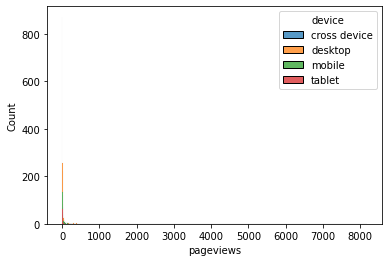

In [38]:
 sns.histplot(data=ga, x='pageviews', hue='device', multiple='stack')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


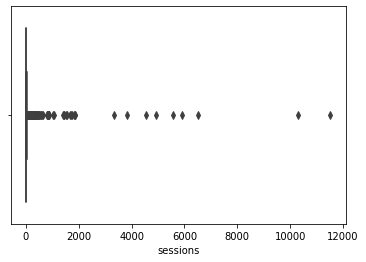

In [39]:
sns.boxplot(ga['sessions'])

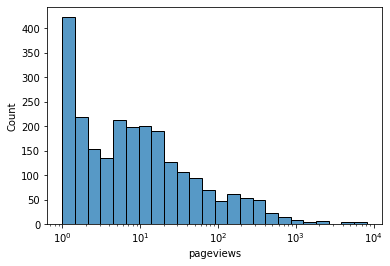

In [40]:
# the horizontal axis has a logarithmic scale due to the skewed data distribution
sns.histplot(data=ga, x='pageviews', log_scale=True)

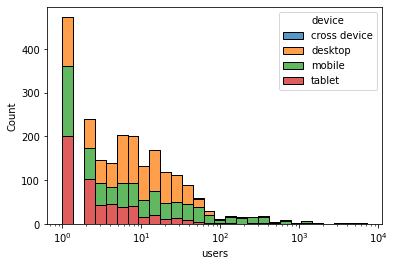

In [41]:
sns.histplot(data=ga, x='users', hue='device', multiple='stack', log_scale=True)

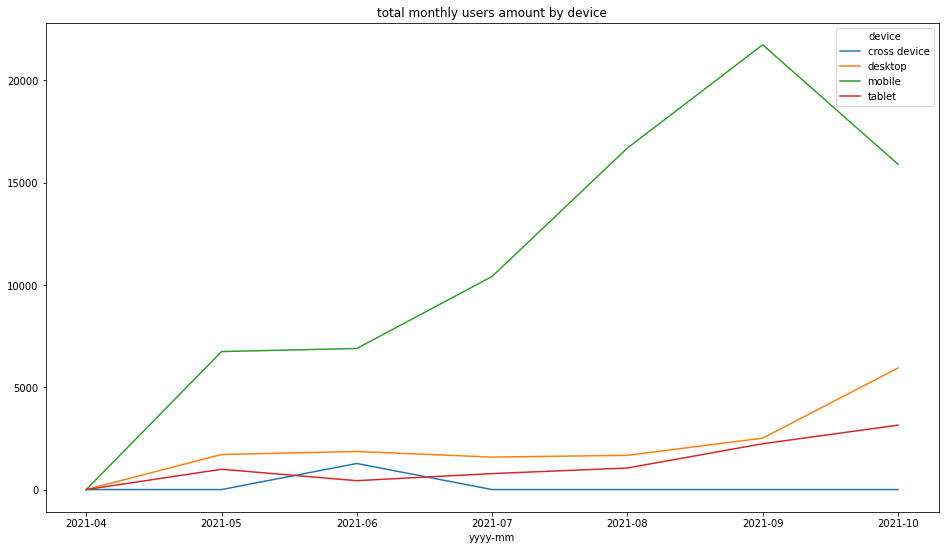

In [42]:
pd.pivot_table(data=ga, index='yyyy-mm', columns='device', values='users', aggfunc='sum').plot(kind='line', figsize=(16,9), title='total monthly users amount by device')

noticing the highly skewed distribution for the users and pageviews variables their histograms were plotted with a horizontal logarithmic scales, because of this, its interpretation about which device segment added the most to the count of users must consider the rightmost portion of the graph (even if the leftmost bars looks bigger), in this case mobile devices are ones with more users amount.

In [43]:
# aggregation to analyze metrics performance by time, device, and source
monthly_agg = ga.groupby(['yyyy-mm', 'device', 'source']).agg({
    'ad_content':'nunique',
    'pageviews':'sum',
    'sessions':'sum',
    'users':'sum',
    'new_users':'sum',
    'session_duration_hr':'mean',
    'pageviews_per_user':'mean',
    'sessions_per_user':'mean',
    'onsite_time_hr':'mean',
    'returning_ratio':'mean'})

In [44]:
monthly_agg = monthly_agg.reset_index()

In [45]:
monthly_agg

,yyyy-mm,device,source,ad_content,pageviews,sessions,users,new_users,session_duration_hr,pageviews_per_user,sessions_per_user,onsite_time_hr,returning_ratio
0,2021-04,cross device,Acuity,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,2021-04,cross device,AdPrime,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2,2021-04,cross device,AdTheorent,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
3,2021-04,cross device,Aptus,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
4,2021-04,cross device,Emodo,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,2021-10,tablet,RemedyHealth,8,28,24,22,22,0.043542,1.300000,1.087500,0.014667,1.000000
528,2021-10,tablet,Sharecare,8,117,93,82,82,0.323264,1.356237,1.049479,0.017657,1.000000
529,2021-10,tablet,Swoop,6,41,36,28,27,0.068704,1.430556,1.208333,0.006439,0.958333
530,2021-10,tablet,WebMD,12,40,33,31,29,0.011875,1.280556,1.044444,0.005694,0.951389


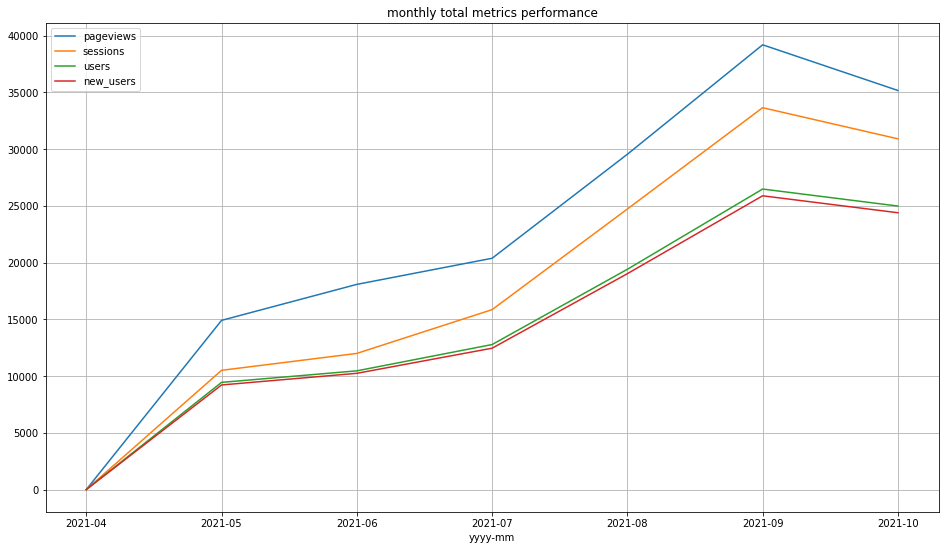

In [46]:
monthly_funnel = monthly_agg.groupby('yyyy-mm')[['pageviews', 'sessions', 'users', 'new_users']]
monthly_funnel.sum().plot(kind='line', title='monthly total metrics performance', grid=True, figsize=(16,9))

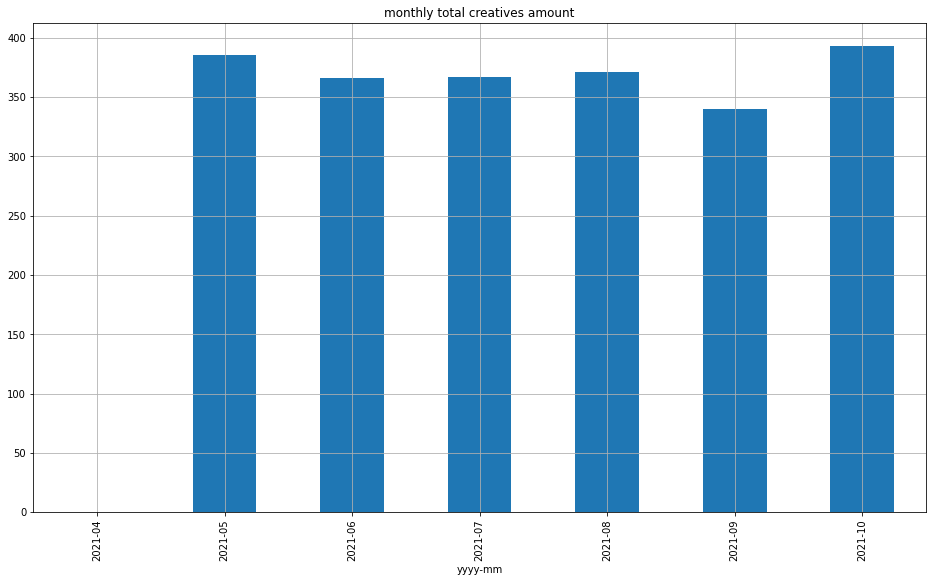

In [47]:
monthly_agg[['yyyy-mm', 'ad_content']].groupby('yyyy-mm')['ad_content'].sum().plot(kind='bar', title='monthly total creatives amount', grid=True, figsize=(16,9))

from the above graph can be infered that this is either a brand new website or an older one which had started to be tracked, it is noticeable that:
- most of the users are new regardless of the month considered, this type of traffic behaviour is characteristic of marketing campaigns (and new sites), depending on their purpose eg. awareness vs consideration vs conversions it could be better interpreted metrics such as ROAS (unavailable in the data) and overall performance.
- the page views is roughly 2 per user, being an indicator of a possible low engagement.
- the campaigns have steadily attracted traffic in an increasing way, as the amount of monthly content has been rather constant (370.5 contents/month) this suggest an increase in efficiency

[Text(0, 0, 'Acuity'),
 Text(0, 0, 'AdPrime'),
 Text(0, 0, 'AdTheorent'),
 Text(0, 0, 'Aptus'),
 Text(0, 0, 'Emodo'),
 Text(0, 0, 'Facebook'),
 Text(0, 0, 'GoodRx'),
 Text(0, 0, 'HealthUnion'),
 Text(0, 0, 'Healthline'),
 Text(0, 0, 'MediaIQ'),
 Text(0, 0, 'Medicx'),
 Text(0, 0, 'MiQ'),
 Text(0, 0, 'ParkinsonsNewsToday'),
 Text(0, 0, 'PulsePoint'),
 Text(0, 0, 'RemedyHealth'),
 Text(0, 0, 'Sharecare'),
 Text(0, 0, 'Swoop'),
 Text(0, 0, 'WebMD'),
 Text(0, 0, 'Zeta')]

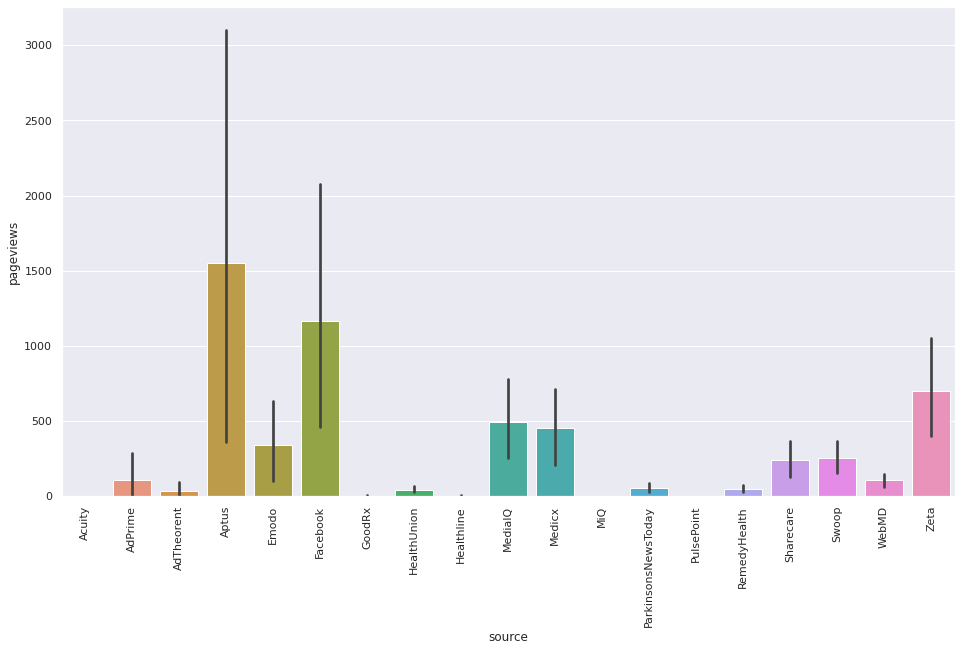

In [48]:
# average pageviews per source
sns.set(rc = {'figure.figsize':(16,9)})
ax = sns.barplot(x='source', y='pageviews', data=monthly_agg)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

- from the above chart it can be seen that Aptus and Facebook are the two adquisition sources
- other secundary sources are Zeta, MediaIQ, and Medicx in that order
- the contribution of the others can be disregarded
- to better understand this distribution is necessary to observe the evolution over time as not all sources might have started at the same time

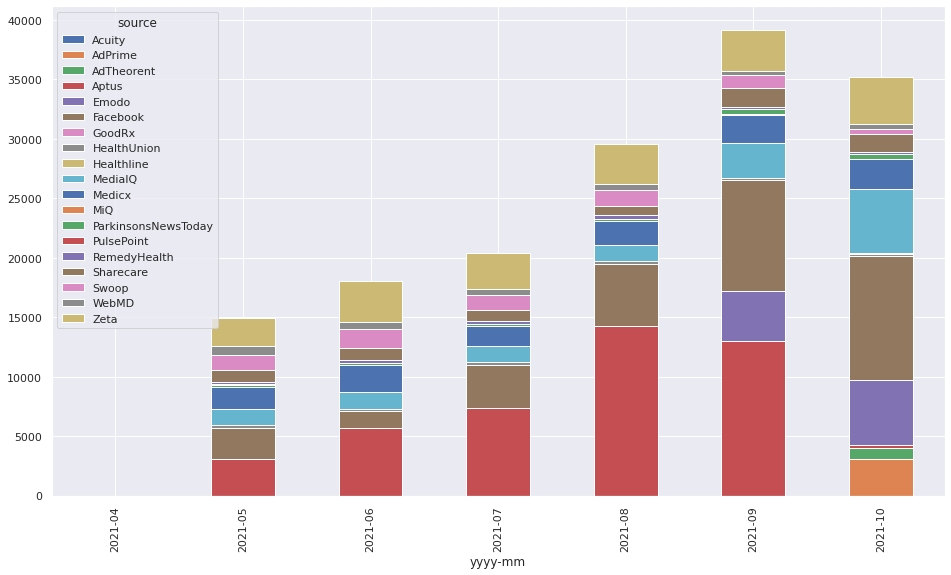

In [49]:
# sum agg
pd.pivot_table(data=monthly_agg, index='yyyy-mm', columns='source', values='pageviews', aggfunc='sum').plot(kind='bar', stacked=True)

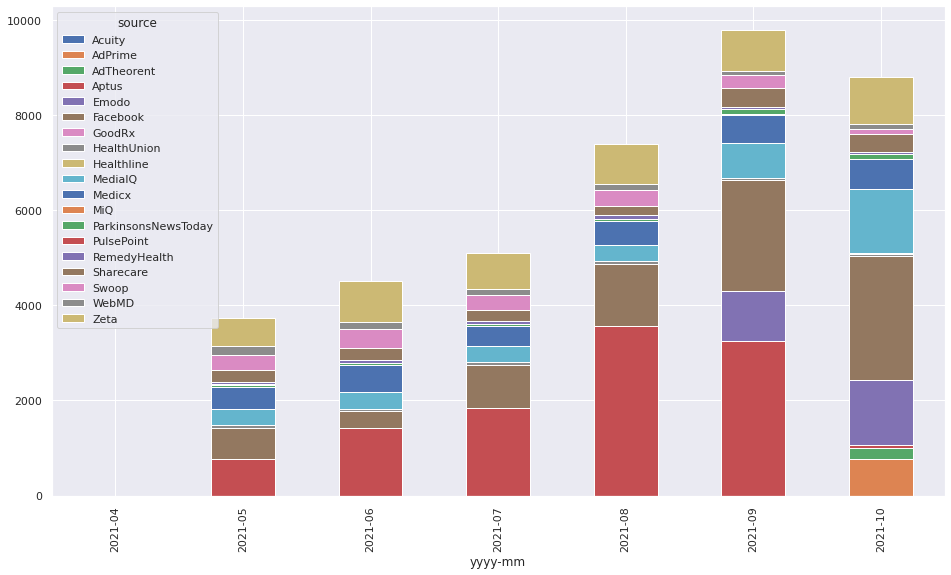

In [50]:
# mean agg
pd.pivot_table(data=monthly_agg, index='yyyy-mm', columns='source', values='pageviews', aggfunc='mean').plot(kind='bar', stacked=True)

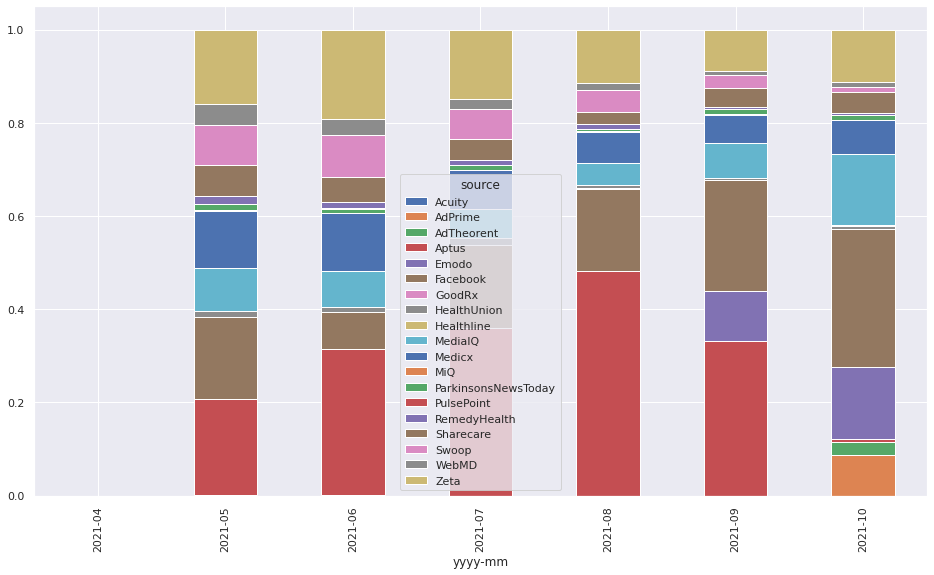

In [51]:
pd.crosstab(index=monthly_agg['yyyy-mm'], columns=monthly_agg['source'], values=monthly_agg['pageviews'], aggfunc='mean', normalize='index').plot(kind='bar', stacked=True)

the above charts confirmed the initial assumptions about Aptus and Facebook as the main sources with the highest average page views, also showed that:
- regardless of its high performance Aptus was absent for October, additional business understanding is required here to know the reasons behind this.
- Emodo and AdPrime can potentially be good sources of interested customers.
- the page view performance as a metric for engagement for Zeta has slightly declined throughout time, and basically disappeared for those coming from GoodRx.
- taking into account that MdialQ and Medicx each represent ~10% of the page views, allocating resources in these might make sense depending on their ROAS/ROI.

In [52]:
views_per_source = monthly_agg.copy()
views_per_source = views_per_source.groupby(['source'])['pageviews_per_user'].mean().sort_values(ascending=False)
views_per_source

source
Facebook               2.356360
MiQ                    2.262778
MediaIQ                2.116067
AdTheorent             2.088939
Zeta                   2.015191
Medicx                 1.991862
Swoop                  1.910293
Emodo                  1.880491
Sharecare              1.751609
WebMD                  1.554911
PulsePoint             1.537037
Aptus                  1.485221
GoodRx                 1.464167
ParkinsonsNewsToday    1.450395
HealthUnion            1.302134
RemedyHealth           1.281874
AdPrime                1.202525
Acuity                 1.142857
Healthline             1.005000
Name: pageviews_per_user, dtype: float64

- regarding MedialIA and Medicx, when normalized by user they are among the sources with potentially most interested traffic.
- MiQ and MediaIQ are treated as different sources, however it is necessary to verify this with relevant parties.

In [53]:
monthly_agg.head()

,yyyy-mm,device,source,ad_content,pageviews,sessions,users,new_users,session_duration_hr,pageviews_per_user,sessions_per_user,onsite_time_hr,returning_ratio
0,2021-04,cross device,Acuity,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,2021-04,cross device,AdPrime,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2,2021-04,cross device,AdTheorent,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
3,2021-04,cross device,Aptus,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
4,2021-04,cross device,Emodo,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN


In [54]:
ga.users.sum()

111089

In [55]:
ga.groupby('device')['users'].sum()

device
cross device     1274
desktop         15279
mobile          78357
tablet           8643
Name: users, dtype: int64

by far the adquired audience comes from mobile devices representing 71% of the total users, and 5.1 times the next device in users (desktop).

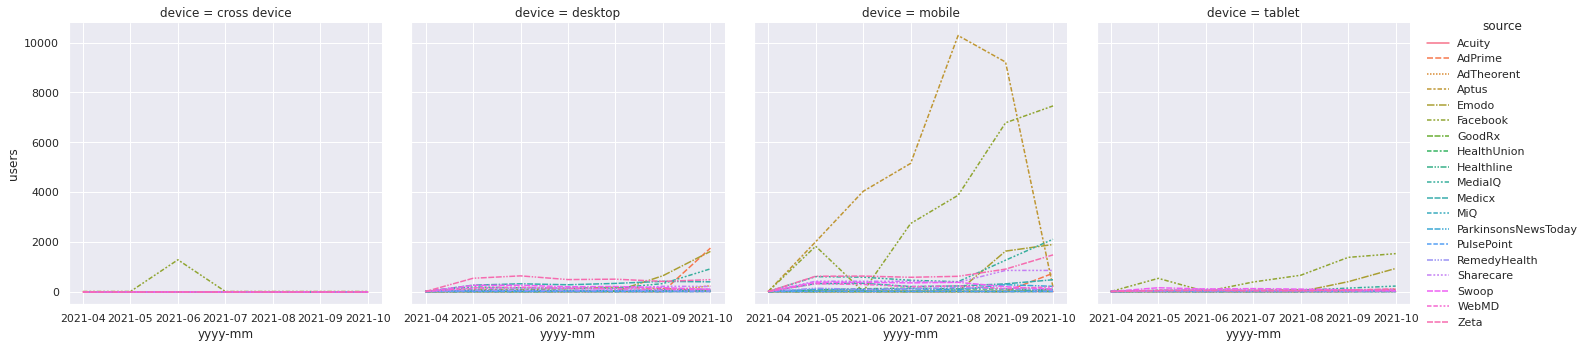

In [56]:
sns.relplot(
    data=ga.groupby(['yyyy-mm', 'device', 'source'])['users'].sum().reset_index(),
    x='yyyy-mm', y='users',
    col='device', hue='source', style='source',
    kind='line'
)

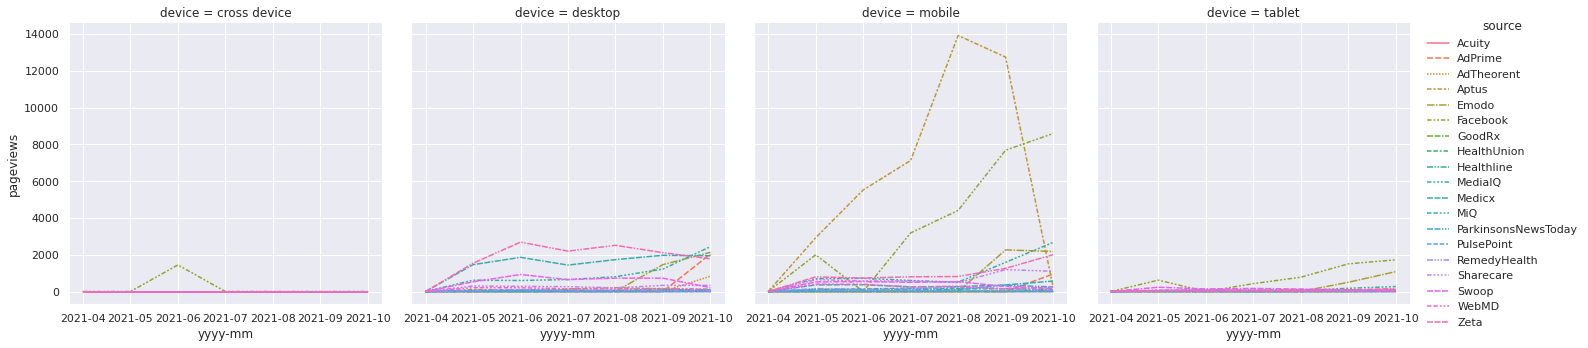

In [57]:
sns.relplot(
    data=ga.groupby(['yyyy-mm', 'device', 'source'])['pageviews'].sum().reset_index(),
    x='yyyy-mm', y='pageviews',
    col='device', hue='source', style='source',
    kind='line'
)

from the graphs above is worth noting that the Aptus source has a particularly high users and page views performance in the mobile segment, surpasing Facebook; the others segments barely contribute to it.

In [58]:
source_metrics = ga.groupby('source').agg({
    'ad_content':'nunique',
    'pageviews':['min', 'mean', 'median', 'max', 'std', 'sum'],
    'sessions':['min', 'mean', 'median', 'max', 'std', 'sum'],
    'session_duration_hr':['min', 'mean', 'median', 'max', 'std'],
    'users':['min', 'mean', 'median', 'max', 'std', 'sum'],
    'new_users':['min', 'mean', 'median', 'max', 'std', 'sum'],
    'pageviews_per_session':['min', 'mean', 'median', 'max', 'std'],
    'pageviews_per_user':['min', 'mean', 'median', 'max', 'std'],
    'sessions_per_user':['min', 'mean', 'median', 'max', 'std'],
    'onsite_time_hr':['min', 'mean', 'median', 'max', 'std'],
    'returning_ratio':['min', 'mean', 'median', 'max', 'std'],
})

In [59]:
source_metrics[('ad_content', 'users_per_campaign')] = source_metrics[('users', 'sum')] / source_metrics[('ad_content', 'nunique')]
source_metrics[('ad_content', 'new_users_per_campaign')] = source_metrics[('new_users', 'sum')] / source_metrics[('ad_content', 'nunique')]

In [60]:
source_metrics

ad_content pageviews                            \
                       nunique       min         mean median   max   
source                                                               
Acuity                       5         1     1.076923    1.0     2   
AdPrime                      1       104  1030.333333  950.0  2037   
AdTheorent                   6         1    51.944444   16.5   175   
Aptus                       18         1   340.396947   12.0  7176   
Emodo                        8         1   246.589744   74.0  1963   
Facebook                     3         4   744.375000  118.0  8179   
GoodRx                      15         1     3.192982    2.0    13   
HealthUnion                 34         1     7.989474    3.0    84   
Healthline                   9         1     5.666667    2.0    22   
MediaIQ                     30         1    46.436709   10.0   894   
Medicx                      25         1    48.494983   11.0   399   
MiQ                          8         1     2.840909    2.0    18   
ParkinsonsNewsToday         14         1    19.902174   10.5   178   
PulsePoint                   7         1     1.647059    1.0     5   
RemedyHealth                15         1     8.729560    5.0    55   
Sharecare                   16         1    44.271186    8.0  1081   
Swoop                       23         1    46.357143   15.5   440   
WebMD                       36         1    13.845283    6.0   131   
Zeta                        33         1    63.665689    8.0  1728   

                                        sessions                            \
                             std    sum      min        mean median    max   
source                                                                       
Acuity                  0.277350     14        1    1.076923    1.0      2   
AdPrime               969.000688   3091       98  923.666667  822.0   1851   
AdTheorent             65.016262    935        1   18.555556   15.5     56   
Aptus                1135.625119  44592        1  296.977099   10.0   6522   
Emodo                 441.671986   9617        1  197.871795   43.0   1693   
Facebook             1672.175442  35730        2  925.145833  117.0  11516   
GoodRx                  2.773849    182        1    2.350877    1.0      9   
HealthUnion            12.959844   1518        1    6.221053    3.0     77   
Healthline              6.637816     68        1    5.583333    2.0     21   
MediaIQ               104.663630  14674        1   28.873418    7.0    780   
Medicx                 90.356244  14500        1   15.779264   11.0    136   
MiQ                     3.154496    125        1    2.659091    2.0     17   
ParkinsonsNewsToday    31.998990   1831        1   16.565217    8.0    148   
PulsePoint              1.114741     28        1    1.470588    1.0      5   
RemedyHealth           10.481258   1388        1    7.012579    4.0     36   
Sharecare             133.757519   7836        1   31.079096    6.0    831   
Swoop                  70.054272   8437        1   28.186813   11.5    268   
WebMD                  21.064355   3669        1   11.494340    6.0    109   
Zeta                  159.823946  21710        1   29.134897    6.0   1534   

                                        session_duration_hr             \
                             std    sum                 min       mean   
source                                                                   
Acuity                  0.277350     14            0.000000   0.000000   
AdPrime               880.911081   2771            2.168056  12.352778   
AdTheorent             18.114740    334            0.000000   0.109198   
Aptus                1004.653499  38904            0.000000   1.953352   
Emodo                 381.775573   7717            0.000000   1.543226   
Facebook             2348.781006  44407            0.000000   3.693229   
GoodRx                  1.977473    134            0.000000   0.055093   
HealthUnion           

In [61]:
source_performance = source_metrics.copy()

source_performance = source_performance[[
    ('ad_content','nunique'), ('ad_content', 'users_per_campaign'), ('ad_content', 'new_users_per_campaign'),
    ('pageviews_per_session','mean'), ('pageviews_per_user','mean'), ('sessions_per_user','mean'),
    ('onsite_time_hr', 'mean'),
    ('users','sum'), ('users','mean'), ('new_users','sum'), ('new_users','mean'), ('returning_ratio', 'mean')]]
source_performance.columns = ['campaigns_amt', 'users_per_campaign', 'new_users_per_campaign',
                       'pageviews_per_session', 'pageviews_per_user', 'sessions_per_user',
                       'onsite_time_hr',
                       'total_users', 'avg_users', 'total_new_users', 'avg_new_users', 'returning_ratio']
source_performance.reset_index(inplace=True)

In [62]:
source_performance

,source,campaigns_amt,users_per_campaign,new_users_per_campaign,pageviews_per_session,pageviews_per_user,sessions_per_user,onsite_time_hr,total_users,avg_users,total_new_users,avg_new_users,returning_ratio
0,Acuity,5,2.600000,2.400000,1.000000,1.076923,1.076923,0.000000,13,1.000000,12,0.923077,0.923077
1,AdPrime,1,2567.000000,2563.000000,1.105809,1.202525,1.086768,0.018287,2567,855.666667,2563,854.333333,0.998445
2,AdTheorent,6,55.666667,54.666667,2.088939,2.088939,1.000000,0.003616,334,18.555556,328,18.222222,0.989590
3,Aptus,18,1779.888889,1734.944444,1.170834,1.604238,1.375269,0.012399,32038,244.564885,31229,238.389313,0.823615
4,Emodo,8,884.750000,861.375000,1.500693,1.654230,1.114522,0.005753,7078,181.487179,6891,176.692308,0.941361
5,Facebook,3,10389.333333,10145.333333,1.232259,2.281205,1.458123,0.026537,31168,649.333333,30436,634.083333,0.804421
6,GoodRx,15,7.933333,7.266667,1.428070,1.771637,1.229532,0.037775,119,2.087719,109,1.912281,0.872320
7,HealthUnion,34,32.852941,29.617647,1.262355,1.341789,1.067336,0.026783,1117,5.878947,1007,5.300000,0.877819
8,Healthline,9,7.333333,7.222222,1.003968,1.008333,1.004167,0.002529,66,5.500000,65,5.416667,0.958333
9,MediaIQ,30,279.266667,277.033333,2.258201,2.323803,1.051657,0.003765,8378,26.512658,8311,26.300633,0.972646


In [63]:
# the most adquisition
source_performance[['source', 'total_new_users']].sort_values('total_new_users', ascending=False)

,source,total_new_users
3,Aptus,31229
5,Facebook,30436
18,Zeta,8844
9,MediaIQ,8311
4,Emodo,6891
15,Sharecare,5083
10,Medicx,4476
16,Swoop,4097
17,WebMD,2674
1,AdPrime,2563


In [64]:
# the most adquisition
source_performance[['source', 'avg_new_users']].sort_values('avg_new_users', ascending=False)

,source,avg_new_users
1,AdPrime,854.333333
5,Facebook,634.083333
3,Aptus,238.389313
4,Emodo,176.692308
15,Sharecare,28.717514
9,MediaIQ,26.300633
18,Zeta,25.935484
16,Swoop,22.510989
2,AdTheorent,18.222222
10,Medicx,14.969900


### visualization

[please follow this link to the dashboard](https://datastudio.google.com/reporting/fd59d69b-3c9e-43a7-b39f-da6401fee8ce)

### conclusions

1. there are very few users returning to the website, depending on the nature and purpose of the campaign and/or landing page this might be a desired or not behaviour.
2. the content channel to prioritize is mobile as is the one gathering more users.
3. metrics such as page views is around 2 pages/user signalling a plausible low engagement.
4. the main gross users adquisition sources are Aptus and Facebook, but AdPrime is the most efficient involving 854 users/content (vs 634 Facebook vs 238 Aptus)
5. additional business context is required to understand the reasons behind the absence of the Aptus source on October.
6. Emodo and AdPrime are potentially good sources of interested customers.
7. the page view performance as a metric for engagement for Zeta has slightly declined throughout time, and basically disappeared for those coming from GoodRx.
8. taking into account that MdialQ and Medicx each represent ~10% of the page views, allocating resources in these might make sense depending on their ROAS/ROI.
9. it is suggested additional data such as GTM events, thank you page visits, ROAS, ROI to complement the findings of this analysis.

## sql assessment

1.	Write a SQL query to fetch the count of employees working in project ‘P1’:

In [65]:
%%bigquery --project publicis-361421
SELECT
  COUNT(DISTINCT(EmpId)) AS NumP1Employees
FROM
  `publicis-361421.employees.EmployeeSalary`
WHERE
  PROJECT = "P1"

,NumP1Employees
0,2


2.	Write a SQL query to fetch project-wise count of employees sorted by project’s count in descending order:

In [66]:
%%bigquery --project publicis-361421
SELECT
  Project,
  COUNT(DISTINCT(EmpId)) AS NumProjectEmployees
FROM
  `publicis-361421.employees.EmployeeSalary`
GROUP BY
  PROJECT
ORDER BY
  PROJECT DESC

,Project,NumProjectEmployees
0,P2,1
1,P1,2


3.	Write a SQL query to fetch employee names having a salary greater than or equal to 5000 and less than or equal 10000:

In [67]:
%%bigquery --project publicis-361421
SELECT
  EmpD.FullName,
  EmpS.Salary
FROM
  `publicis-361421.BucketEmployees.EmployeeDetails` AS EmpD
LEFT JOIN
  `publicis-361421.BucketEmployees.EmployeeSalary` AS EmpS
ON
  EmpD.EmpId = EmpS.EmpId
WHERE
  EmpS.Salary BETWEEN 5000
  AND 10000

,FullName,Salary
0,John Snow,8000


4.	Write a query to fetch employee names and salary records. Return employee details even if the salary record is not present for the employee:

In [68]:
%%bigquery --project publicis-361421
SELECT
  EmpD.*,
  EmpS.Salary
FROM
  `publicis-361421.BucketEmployees.EmployeeDetails` AS EmpD
LEFT JOIN
  `publicis-361421.BucketEmployees.EmployeeSalary` AS EmpS
ON
  EmpD.EmpId = EmpS.EmpId

,EmpId,FullName,ManagerId,DateOfJoining,Salary
0,421,Kuldeep Rana,876,11/27/2016,12000
1,121,John Snow,321,01/31/2014,8000
2,321,Walter White,986,01/30/2015,1000


In [69]:
%%bigquery --project publicis-361421
select *
from `publicis-361421.BucketEmployees.EmployeeDetails`

,EmpId,FullName,ManagerId,DateOfJoining
0,421,Kuldeep Rana,876,11/27/2016
1,121,John Snow,321,01/31/2014
2,321,Walter White,986,01/30/2015


In [70]:
%%bigquery --project publicis-361421
select *
from `publicis-361421.BucketEmployees.EmployeeSalary`

,EmpId,Project,Salary
0,121,P1,8000
1,421,P1,12000
2,321,P2,1000


5.	Write a SQL query to create a new table with data and structure copied from another table:

In [71]:
%%bigquery --project publicis-361421
-- if executed more than once it will notify the existence of the already created table
CREATE TABLE
`publicis-361421.BucketEmployees.EmploeeDetailsCloned`
CLONE `publicis-361421.BucketEmployees.EmployeeDetails`

Executing query with job ID: ed2762b3-9f3b-4461-a0e3-a6fec99bb3b9
Query executing: 0.33s


ERROR:
 409 GET https://bigquery.googleapis.com/bigquery/v2/projects/publicis-361421/queries/ed2762b3-9f3b-4461-a0e3-a6fec99bb3b9?maxResults=0&timeoutMs=400&location=us-central1: Already Exists: Table publicis-361421:BucketEmployees.EmploeeDetailsCloned

(job ID: ed2762b3-9f3b-4461-a0e3-a6fec99bb3b9)

                              -----Query Job SQL Follows-----                               

    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |
   1:-- if executed more than once it will notify the existence of the already created table
   2:CREATE TABLE
   3:`publicis-361421.BucketEmployees.EmploeeDetailsCloned`
   4:CLONE `publicis-361421.BucketEmployees.EmployeeDetails`
    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |


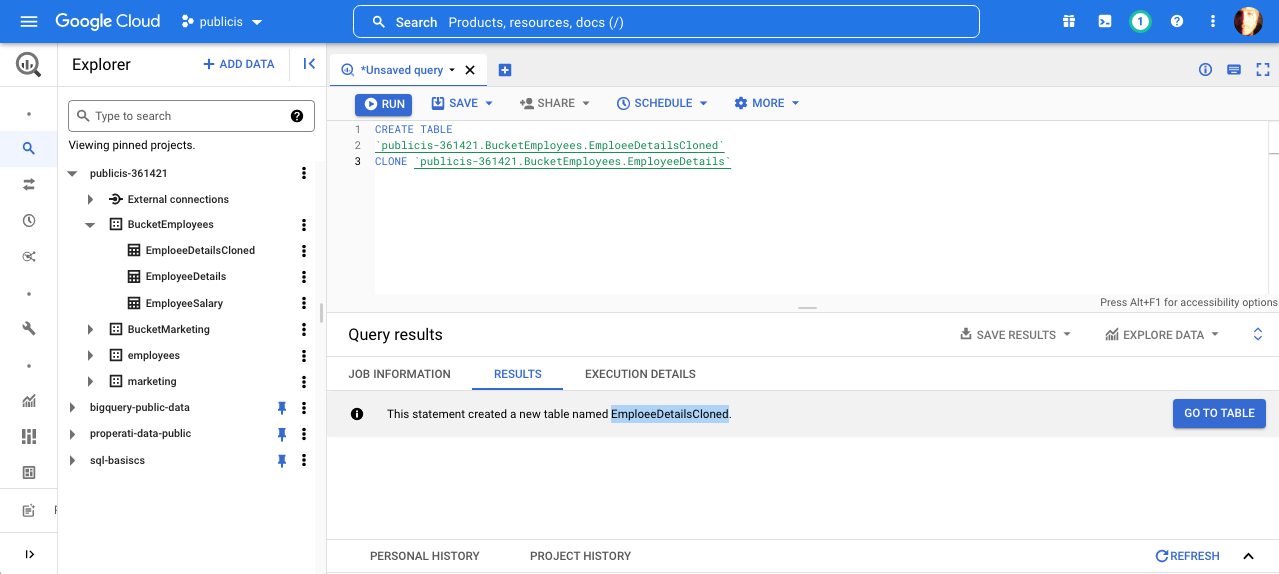

6.	Write a SQL query to fetch all the Employees details from EmployeeDetails table who joined in the Year 2016

In [72]:
%%bigquery --project publicis-361421
/* this database update is to homogenize the format of the column
so the next date extraction step don't return errors */
UPDATE
  `publicis-361421.BucketEmployees.EmployeeDetails`
SET
  DateOfJoining = '11/27/2016'
WHERE
  EmpId = 421

""


In [73]:
%%bigquery --project publicis-361421
SELECT
  *
FROM
  `publicis-361421.BucketEmployees.EmployeeDetails`
WHERE
  EXTRACT(year
  FROM
    PARSE_DATE('%m/%d/%Y', DateOfJoining) ) = 2016

,EmpId,FullName,ManagerId,DateOfJoining
0,421,Kuldeep Rana,876,11/27/2016


## resources

data sources:
- [google analytics spreadsheet](https://docs.google.com/spreadsheets/d/16Om0tT4Dh_RKn9n2eTIY_TdTYPOGRSXFAdBa-7LFCBY/edit?usp=sharing)
- [doubleclick spreadsheet](https://docs.google.com/spreadsheets/d/1NTPnff7UAlk686gAzKFslp2WKPrR_w71u9JMNAP0JKY/edit?usp=sharing)
- google cloud bucket
  - [google analytics dataset](https://storage.googleapis.com/publicis-data/google%20analytics.csv)
  - [doubleclick manager dataset](https://storage.googleapis.com/publicis-data/doubleclick%20campaign%20manager.csv)
  - sql assestment - [employee details table](https://storage.googleapis.com/publicis-data/EmployeeDetails.csv)
  - sql assestment - [employee salary table](https://storage.googleapis.com/publicis-data/EmployeeSalary.csv)

analysis
- [cleaned/cannonical dataset](https://storage.googleapis.com/publicis-data/ga.csv)
- [colab notebook](https://colab.research.google.com/drive/1_yO1rl3Utx0EgzVNVL5jU4JzzJ8Ak91B?usp=sharing)

visualization
- [dashboard](https://datastudio.google.com/s/rJdqqYurdpA)

project
- [github repository](https://github.com/atzzom/pdg/blob/main/pdg%20-%20pedro%20avila.ipynb)